In [1]:
import torch
import sys
sys.path.append('../')
from GNN_Models import GNN3_Multisolvent_embedding
from GNN_Models import GNN3_Multisolvent_embedding_run_multiple
import yaml
solvent_dict = yaml.load(open("../Simulation/solvents.yml"), Loader=yaml.FullLoader)[
    "solvent_mapping_dict"
]
from torch.utils.data import DataLoader
import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from GNN_Trainer import Trainer
import numpy as np

In [2]:
folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/"

In [3]:
test_set = torch.load(f"{folder}/datasets/test_set.pt")

# Split up testdata into solvents

In [4]:
import pickle
filehandler = open(f"{folder}/trained_models/results_dict_all_models.pkl","rb")
comparison_dict = pickle.load(filehandler)

In [5]:
test_data_dict = {}
for solvent in solvent_dict.keys():
    test_data_dict[solvent] = [dp for dp in test_set if dp.solvent_model_tensor[0] == solvent_dict[solvent]["solvent_id"]]

In [6]:
for random_seed in [1611,1612,1613]:
    if random_seed in comparison_dict.keys():
        continue
    train_dict = torch.load(f"{folder}/trained_models/ProductionRun_seed_{random_seed}_49_ckpt.pt")
    model_dict = train_dict["model"]

    model = GNN3_Multisolvent_embedding(num_solvents=42,device="cpu")
    model.load_state_dict(model_dict)
    model.eval()

    results_dict = {}

    for solvent in tqdm.tqdm(solvent_dict.keys()):

        pre = []
        tru = []

        datal = DataLoader(test_data_dict[solvent], batch_size=None, shuffle=False)
        for dp in datal:
            e,f = model(dp)
            pre.append(f.detach().to("cpu").numpy())
            tru.append(dp.forces.detach().to("cpu").numpy())
            dp = None
        
        results_dict[solvent] = (pre,tru)

    metric_dict = {}

    for solvent in results_dict.keys():
        pre, tru = results_dict[solvent]


        mae = mean_absolute_error(np.concatenate(tru),np.concatenate(pre))
        rmse = np.sqrt(mean_squared_error(np.concatenate(tru),np.concatenate(pre)))
        r2 = r2_score(np.concatenate(tru),np.concatenate(pre))
        pearson = pearsonr(np.concatenate(tru).flatten(),np.concatenate(pre).flatten()).statistic

        metric_dict[solvent] = (mae,rmse,r2,pearson)

    df = pd.DataFrame.from_dict(metric_dict,orient="index",columns=["MAE","RMSE","R2","Pearson"])
    df.head()
    df.sort_values("RMSE",ascending=True,inplace=True)
    comparison_dict[random_seed] = df

In [7]:
comparison_dict[1612]["RMSE"].mean(), comparison_dict[1611]["RMSE"].mean(), comparison_dict[1613]["RMSE"].mean()

(15.84272, 15.807248, 15.795142)

In [8]:
# import pickle
# pickle.dump(comparison_dict, open("results_dict_all_models.pkl","wb"))

In [9]:
plot_folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/manuscript/Plots/"

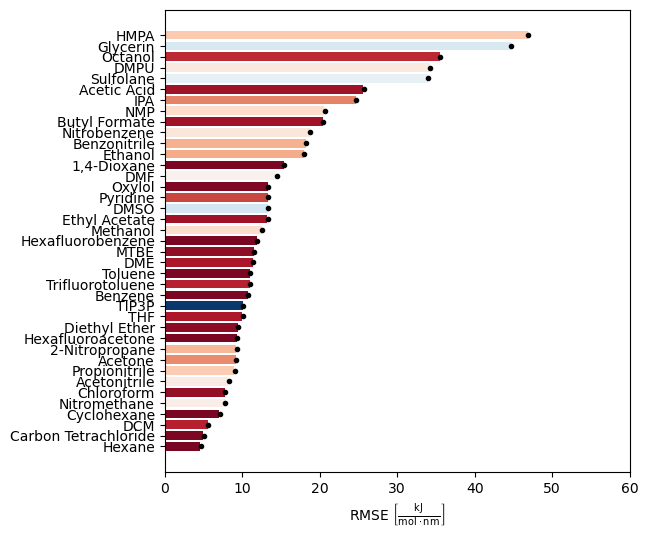

In [10]:
all_errors = np.stack([comparison_dict[1612]["RMSE"].values, comparison_dict[1611]["RMSE"].values, comparison_dict[1613]["RMSE"].values])
fig, axd = plt.subplot_mosaic([["bar"]],figsize=(6,6))
ax = axd["bar"]
colors = plt.cm.RdBu([solvent_dict[s]["dielectric"]/80 for s in list(comparison_dict[1612].index)])
names = [solvent_dict[s]["nice_name"] for s in list(comparison_dict[1612].index)]

ax.barh(names,all_errors.mean(axis=0),color=colors)
ax.errorbar(comparison_dict[1612]["RMSE"],names,xerr=all_errors.std(axis=0),fmt='.',color="black")
# _ = ax.get_xticks()(rotation=90)
ax.set_xlabel(r"RMSE $\left [\frac{\mathrm{kJ}}{\mathrm{mol} \cdot \mathrm{nm}} \right ]$")
ax.set_xlim(0,60)
plt.savefig(f"{plot_folder}/SolventRMSEs.pdf",bbox_inches="tight")

In [11]:
np.max(all_errors.std(axis=0))

0.0504682

#### Ref Yao et al. 0.393 kcal/mol/Å for water ref aprox 16 kJ/mol/nm

In [12]:
import matplotlib as mpl
# import inset axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def plot_forces_comparison(
        pre,
        tru,
        max_s=None,
        hist_bins=1000,
        iax=None,
        yticks=([10000, 100000], [r"$10^{5}$", r"$10^{6}$"]),
    ):

        pre = np.array(pre).flatten()
        tru = np.array(tru).flatten()
        print("RMSE: %.3f" % np.sqrt(mean_squared_error(tru, pre)))
        if iax is None:
            axd = plt.figure(constrained_layout=True).subplot_mosaic(
                [["trupre"]], empty_sentinel="BLANK", gridspec_kw={"width_ratios": [1]}
            )
            ax = axd["trupre"]
        else:
            ax = iax

        hist, x, y, im = ax.hist2d(
            tru, pre, bins=hist_bins, norm=mpl.colors.LogNorm(), zorder=2, cmap=custom_cmap
        )
        if max_s is None:
            max_s = np.max([np.abs(pre), np.abs(tru)])
        ax.plot([-max_s, max_s], [-max_s, max_s], zorder=1,c="black")
        ax.set_xlabel(
            r"Explicit Mean Force $\left [\frac{\mathrm{kJ}}{\mathrm{mol} \cdot \mathrm{nm}} \right ]$"
        )
        ax.set_ylabel(
            r"Predicted Mean Force $\left [\frac{\mathrm{kJ}}{\mathrm{mol} \cdot \mathrm{nm}} \right ]$"
        )
        ax.set_xlim([-max_s, max_s])
        ax.set_ylim([-max_s, max_s])
        ax.set_aspect("equal")
        plt.colorbar(
            im,
            ax=ax,
            location="right",
            shrink=0.5,
            ticks=[1, 10, 100, 1000, 10000, 100000],
            label=r"Count",
        )

        # Make inset with histogram
        axins = inset_axes(
            ax,
            width="45%",
            height="45%",
            loc="lower right",
            bbox_to_anchor=(0, 0.075, 1, 1),
            bbox_transform=ax.transAxes,
        )
        maxdistance = np.max(np.abs(tru - pre))
        axins.set_facecolor((1, 1, 1, 0))
        axins.hist(
            tru - pre,
            bins=hist_bins,
            # color= rgb_norm((102,1,23)),
            # edgecolor= rgb_norm((102,1,23)),
            color = rgb_norm((0,0,0)),
            edgecolor = rgb_norm((0,0,0)),
            linewidth=0.1,
            histtype="stepfilled",
        )
        axins.grid(False)
        axins.spines["right"].set_visible(False)
        axins.spines["top"].set_visible(False)
        axins.spines["left"].set_visible(False)
        axins.set_yticks(yticks[0], yticks[1])
        axins.tick_params(
            axis="y", colors="black", length=10, width=1, direction="inout"
        )
        axins.set_xlim([-maxdistance, maxdistance])
        axins.set_xticks(
            [-maxdistance, 0, maxdistance],
            ["%i" % int(-maxdistance), r"$\Delta$ F", "%i" % int(maxdistance)],
        )
        axins.yaxis.set_ticks_position("right")
        axins.spines["right"].set_position("center")
        axins.xaxis.set_ticks_position("bottom")
        axins.yaxis.set_visible(True)


In [13]:
#define custom colormap from white to red
def rgb_norm(tup):

    return (tup[0]/255,tup[1]/255,tup[2]/255)

custom_cmap = mpl.colors.LinearSegmentedColormap.from_list([ "red","orange", "white"], [(0, rgb_norm((102,1,23))), (0.4, rgb_norm((231,131,104))), (1, rgb_norm((255,255,255)))])
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list([ "red","orange", "white"], [(0, rgb_norm((0,0,0))), (0.4, rgb_norm((170,170,170))), (1, rgb_norm((255,255,255)))])

In [14]:
random_seed = 1612
train_dict = torch.load(f"{folder}/trained_models/ProductionRun_seed_{random_seed}_49_ckpt.pt")
model_dict = train_dict["model"]

model = GNN3_Multisolvent_embedding(num_solvents=42,device="cpu")
model.load_state_dict(model_dict)
model.eval()

results_dict = {}

for solvent in tqdm.tqdm(solvent_dict.keys()):

    pre = []
    tru = []

    datal = DataLoader(test_data_dict[solvent], batch_size=None, shuffle=False)
    for dp in datal:
        e,f = model(dp)
        pre.append(f.detach().to("cpu").numpy())
        tru.append(dp.forces.detach().to("cpu").numpy())
        dp = None
    
    results_dict[solvent] = (pre,tru)

100%|██████████| 39/39 [11:34<00:00, 17.81s/it]  


### Plot solvent forcedistributions

In [15]:
solvent_dict.keys()

dict_keys(['tip3p', 'Chloroform', 'Methanol', 'DMSO', 'DMPU', 'Diethylether', 'Ethanol', 'DMF', 'DCM', 'Toluol', 'Benzol', 'Hexan', 'acetonitrile', 'acetone', 'aceticacid', '14dioxane', 'nitrobenzol', 'HMPA', 'MTBE', 'IPA', 'Hexafluorobenzene', 'pyridine', 'THF', 'Ethylacetate', 'Sulfolane', 'nitromethane', 'Butylformate', 'NMP', 'Octanol', 'cyclohexane', 'glycerin', 'carbontetrachloride', 'DME', '2Nitropropane', 'Trifluorotoluene', 'hexafluroacetone', 'Propionitrile', 'Benzonitrile', 'oxylol'])

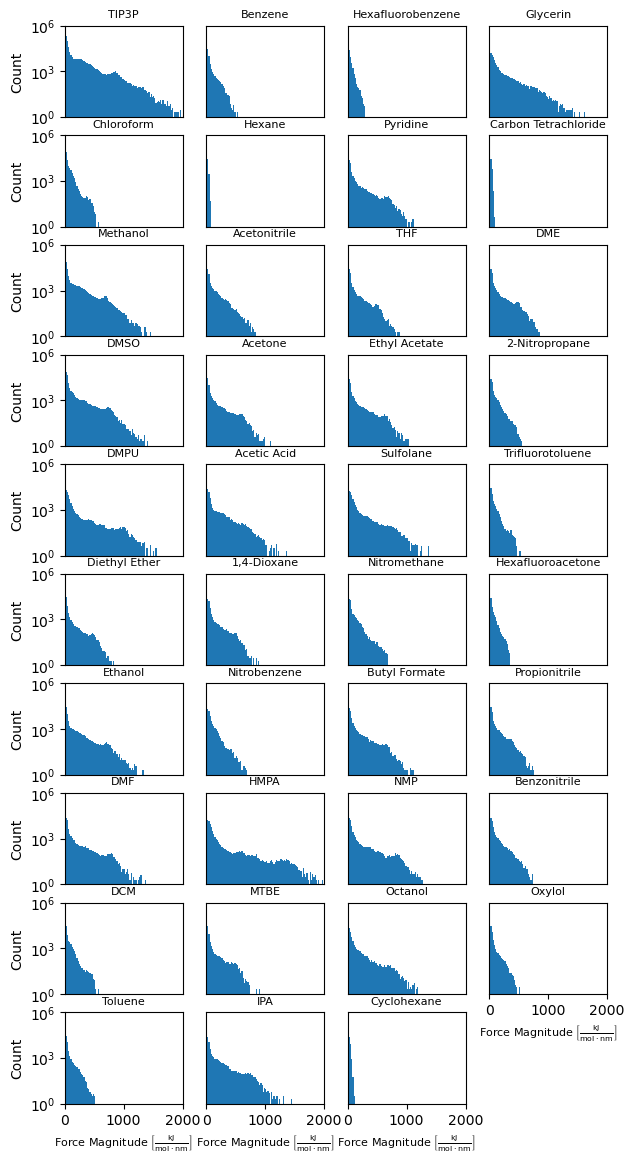

In [21]:
fig, axd = plt.subplot_mosaic([[f'{j}_{i}' for i in range(4)] for j in range(10)],figsize=(7,14))

axd["9_3"].set_visible(False)

for ax in axd.values():
    ax.set_xlabel(r"Force Magnitude $\left [\frac{\mathrm{kJ}}{\mathrm{mol} \cdot \mathrm{nm}} \right ]$",fontdict={"fontsize":8})
    ax.set_ylabel("Count")
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

for i,solvent in enumerate(solvent_dict.keys()):
    
    k = i % 10
    j = i // 10

    pre,tru = results_dict[solvent]
    ax = axd[f'{k}_{j}']
    ax.hist(np.concatenate([np.linalg.norm(t,axis=1) for t in tru]),bins=np.arange(0,2000,20),log=True)
    ax.set_title(f"{solvent_dict[solvent]['nice_name']}",fontdict={"fontsize":8})
    ax.set_xlim(0,2000)
    ax.set_ylim(1,1e6)

    if j == 0:
        ax.get_yaxis().set_visible(True)
    if (k == 9) or (j==3 and k==8):
        ax.get_xaxis().set_visible(True)


plt.savefig(f"{plot_folder}/ForceMagnitudeDistributions.pdf",bbox_inches="tight")

RMSE: 17.161


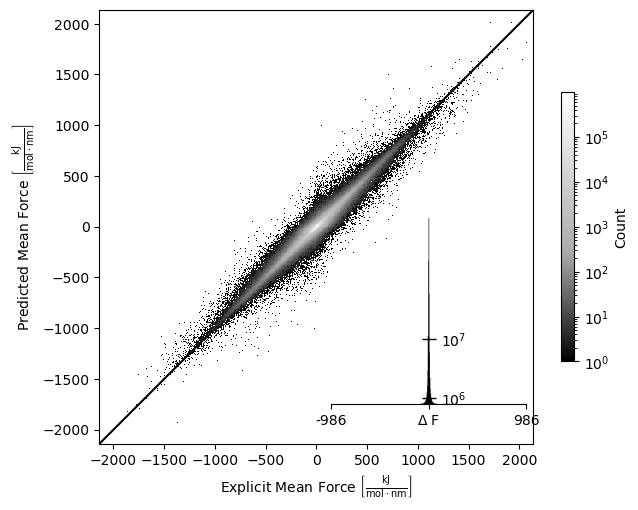

In [15]:
all_pre = []
all_tru = []
for solvent in results_dict.keys():
    pre, tru = results_dict[solvent]
    all_pre += pre
    all_tru += tru

fig,axd = plt.subplot_mosaic(
    [["trupre"]], empty_sentinel="BLANK", gridspec_kw={"width_ratios": [1]},figsize=(7,7)
)

plot_forces_comparison(np.concatenate(all_pre),np.concatenate(all_tru),hist_bins=500,yticks=([100000, 1000000], [r"$10^{6}$", r"$10^{7}$"]),iax=axd["trupre"])

fig.savefig(f"{plot_folder}/Force_Correlation.pdf",bbox_inches="tight")

## visualize embeddings

In [14]:
train_dict = torch.load(f"{folder}/trained_models/ProductionRun_seed_1612_49_ckpt.pt")
model_dict = train_dict["model"]

model = GNN3_Multisolvent_embedding(num_solvents=42,device="cpu")
model.load_state_dict(model_dict)
model.eval()

GNN3_Multisolvent_embedding(
  (_distancer): PairwiseDistance()
  (aggregate_information): GBNeck_interaction()
  (calculate_energies): GBNeck_energies_no_dielectric()
  (lin): Linear(in_features=1, out_features=1, bias=True)
  (solvent_embedding): Embedding(42, 64)
  (gamma_embedding): Embedding(42, 1)
  (interaction1): IN_layer_all_swish_2pass_tokens()
  (interaction2): IN_layer_all_swish_2pass_tokens()
  (interaction3): IN_layer_all_swish_2pass_tokens()
  (dropout): Dropout(p=0.0, inplace=False)
  (_silu): SiLU()
  (sigmoid): Sigmoid()
)

In [15]:
solvent_ids = [solvent_dict[solvent]["solvent_id"] for solvent in solvent_dict]
solvent_dielectric = [solvent_dict[solvent]["dielectric"] for solvent in solvent_dict]
solvent_names = [solvent for solvent in solvent_dict]
solvent_nice_names = [solvent_dict[solvent]["nice_name"] for solvent in solvent_dict]
o_arr = model.solvent_embedding(torch.tensor(solvent_ids,dtype=torch.long)).detach().numpy()

# perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(o_arr)
arr = pca.transform(o_arr)
pca.explained_variance_ratio_

array([0.21965879, 0.14587055, 0.10557774], dtype=float32)

In [16]:
selarr = arr[(arr[:,0] < 0.1) & (arr[:,1] < 0.3)]
sel_solvent_dielectric = np.array(solvent_dielectric)[(arr[:,0] < 0.1) & (arr[:,1] < 0.3)]

In [17]:
np.argwhere(((arr[:,0] < 0.1) & (arr[:,1] < 0.3)).flatten()).flatten()

array([ 0,  2,  3,  4,  5,  6,  7,  9, 10, 12, 13, 14, 15, 17, 18, 19, 21,
       22, 23, 24, 26, 27, 28, 30, 32, 36, 37, 38])

In [18]:
from matplotlib import cm

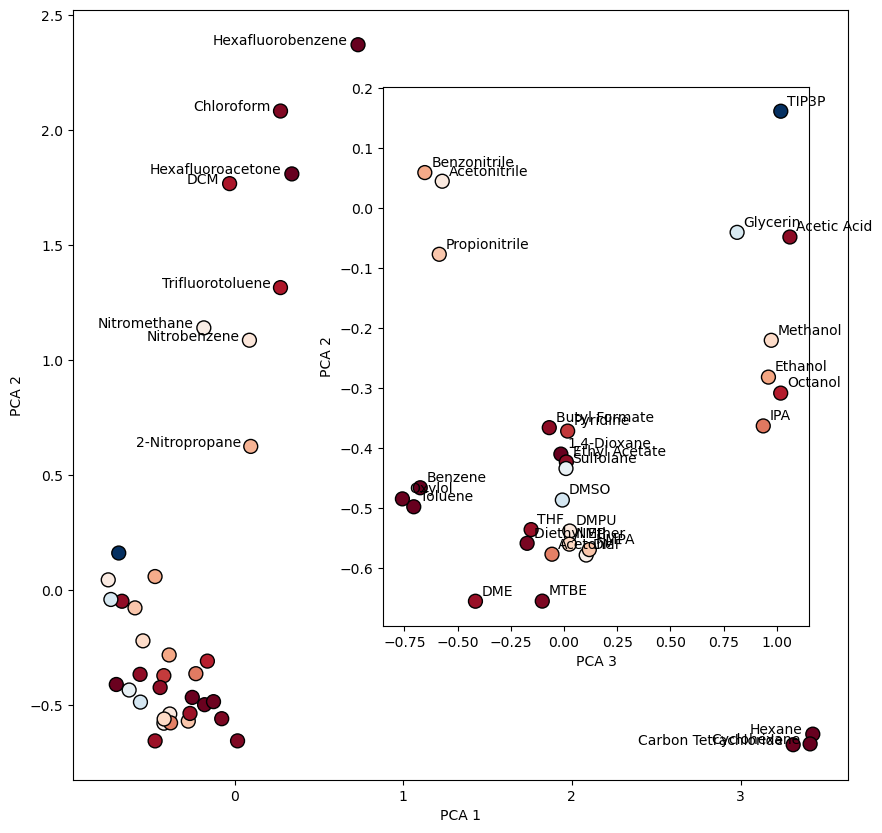

In [19]:
fig, axd = plt.subplot_mosaic([["main"]],figsize=(10,10))

ax = axd["main"]

ax.scatter(arr[:,0],arr[:,1],c=solvent_dielectric,cmap=cm.RdBu,s=100,marker="o",edgecolor="black")

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")

for i in np.argwhere(~((arr[:,0] < 0.1) & (arr[:,1] < 0.3))).flatten():
    ax.text(arr[i,0]-0.06,arr[i,1],solvent_nice_names[i],horizontalalignment="right")

iax = ax.inset_axes([0.4,0.2,0.55,0.7])
iax.set_xlabel("PCA 3")
iax.set_ylabel("PCA 2")

# ax.indicate_inset((np.min(arr[:,0]),np.min(arr[:,1]),0.1-np.min(arr[:,0]),0.2-np.min(arr[:,1])),iax, edgecolor="black")

i1 = 2
i2 = 1
iax.scatter(selarr[:,i1],selarr[:,i2],c=sel_solvent_dielectric,cmap=cm.RdBu,s=100,marker="o",edgecolor="black")
for i in np.argwhere((arr[:,0] < 0.1) & (arr[:,1] < 0.3)).flatten():
    iax.text(arr[i,i1]+0.03,arr[i,i2]+0.01,solvent_nice_names[i])

plt.savefig(f"{plot_folder}/PCA_SolventEmbedding.pdf",bbox_inches="tight")

TIP3P
Methanol
DMSO
DMPU
Diethyl Ether
Ethanol
DMF
Toluene
Benzene
Acetonitrile
Acetone
Acetic Acid
1,4-Dioxane
HMPA
MTBE
IPA
Pyridine
THF
Ethyl Acetate
Sulfolane
Butyl Formate
NMP
Octanol
Glycerin
DME
Propionitrile
Benzonitrile
Oxylol


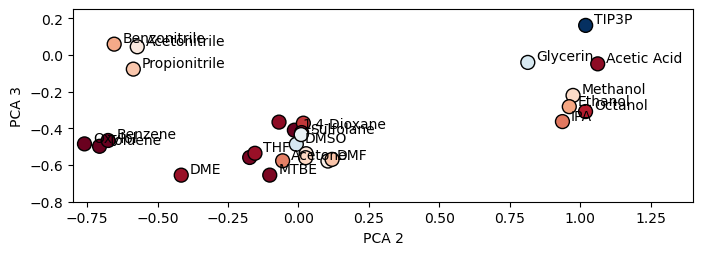

In [37]:
fig, axd = plt.subplot_mosaic([["main"]],figsize=(8,2.5))

ax = axd["main"]

# ax.scatter(arr[:,2],arr[:,1],c=solvent_dielectric,cmap=cm.RdBu,s=100,marker="o",edgecolor="black")

ax.set_xlabel("PCA 2")
ax.set_ylabel("PCA 3")

# for i in np.argwhere(~((arr[:,0] < 0.1) & (arr[:,1] < 0.3))).flatten():
#     ax.text(arr[i,0]-0.06,arr[i,1],solvent_nice_names[i],horizontalalignment="right")

# iax = ax.inset_axes([0.4,0.2,0.55,0.7])
# iax.set_xlabel("PCA 3")
# iax.set_ylabel("PCA 2")

# ax.indicate_inset((np.min(arr[:,0]),np.min(arr[:,1]),0.1-np.min(arr[:,0]),0.2-np.min(arr[:,1])),iax, edgecolor="black")
i1 = 2
i2 = 1
ax.scatter(selarr[:,i1],selarr[:,i2],c=sel_solvent_dielectric,cmap=cm.RdBu,s=100,marker="o",edgecolor="black")
for i in np.argwhere((arr[:,0] < 0.1) & (arr[:,1] < 0.3)).flatten():
    print(solvent_nice_names[i])
    if solvent_nice_names[i] in ["TIP3P","Methanol","Ethanol","Acetone","DMSO","DMF","Acetonitrile","THF","Toluene",
                                 "Benzene","Propionitrile","Benzonitrile","Glycerin","Octanol","IPA","DME","MTBE",
                                 "Sulfolane","Acetic Acid","1,4-Dioxane","Oxylol"]:
        ax.text(arr[i,i1]+0.03,arr[i,i2]+0.01,solvent_nice_names[i])

ax.set_xlim(-0.8,1.4)
ax.set_ylim(-0.8,0.25)

plt.savefig(f"{plot_folder}/PCA_SolventEmbedding_2pca.pdf",bbox_inches="tight")